# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

rewards = env_info.rewards
print('reward shape', len(rewards))
print('rewards', rewards)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
reward shape 2
rewards [0.0, 0.0]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(3):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    steps = 0
    while True:
        steps += 1
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        print('\repisode {} - steps {} - rewards {} | scores {} - done {}'.format(i,steps,rewards,scores,dones), end='')

        if np.any(dones):                                  # exit loop if episode finished
            break
            
    print('\nScore (max over agents) from episode {}: {}\n'.format(i, np.max(scores)))

episode 0 - steps 15 - rewards [0.0, -0.009999999776482582] | scores [ 0.   -0.01] - done [True, True]
Score (max over agents) from episode 0: 0.0

episode 1 - steps 13 - rewards [0.0, -0.009999999776482582] | scores [ 0.   -0.01] - done [True, True]
Score (max over agents) from episode 1: 0.0

episode 2 - steps 15 - rewards [0.0, -0.009999999776482582] | scores [ 0.   -0.01] - done [True, True]
Score (max over agents) from episode 2: 0.0



When finished, you can close the environment.

### 4. Train Policy 

Now it's time to train the agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
%matplotlib inline
import time
import torch
from maddpg import MADDPG, Agent
from collections import deque
import matplotlib.pyplot as plt
import time, os

In [8]:
maddpg = MADDPG(24, 2, 2, 1976)
agent = Agent(24,2,2,1976)

In [9]:
scores_max_hist = []
scores_mean_hist = []

def maddpg_train(n_episodes=1440):
    
    scores_deque = deque(maxlen=100)
    solved = False
    
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        scores = np.zeros(num_agents)
        maddpg.reset()
        step = 0
        while True:
            step += 1
            action = maddpg.act(state, i_episode, add_noise=True)
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            
            scores += reward
            
            maddpg.step(i_episode, state, action, reward, next_state, done)
            
            if np.any(done):
                break
                
            state = next_state
            
        score_max = np.max(scores)
        scores_deque.append(score_max)
        score_mean = np.mean(scores_deque)
        
        scores_max_hist.append(score_max)
        scores_mean_hist.append(score_mean)

        print('\r{} episode\tavg score {:.5f}\tmax score {:.5f}'.format(i_episode, np.mean(scores_deque), score_max), end='')
        if solved == False and score_mean >= 0.5:
            print('\nEnvironment solved after {} episodes with the average score {}\n'.format(i_episode, score_mean))
            maddpg.save()
            solved = True
            torch.save(agent.actor_local.state_dict(), 'actor_local.pth') 
            torch.save(agent.critic_local.state_dict(), 'critic_local.pth')              
            torch.save(agent.actor_target.state_dict(), 'actor_target.pth') 
            torch.save(agent.critic_target.state_dict(), 'critic_target.pth')
            break
        
        if i_episode % 500 == 0:
            print()
      
       

In [10]:
start_time = time.time()
maddpg_train()
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

0 episode	avg score 0.00000	max score 0.00000
500 episode	avg score 0.01250	max score 0.00000
1000 episode	avg score 0.06010	max score 0.10000
1258 episode	avg score 0.52390	max score 2.60000
Environment solved after 1258 episodes with the average score 0.523900007866323


Total Training time = 45.5 min


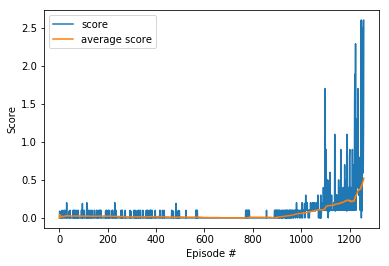

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_max_hist)+1), scores_max_hist, label='score')
plt.plot(np.arange(1, len(scores_mean_hist)+1), scores_mean_hist, label='average score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()